In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
import lightgbm as lgb

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submit.csv')

In [5]:
train.head()

,id,goal,country,duration,category1,category2,html_content,state
0,0,4001-5000,CH,29,publishing,young adult,"<div class=""contents""><div><span class=""bold"">...",0
1,1,3001-4000,NL,34,fashion,ready-to-wear,"<div class=""contents""><div><h1 class=""page-anc...",0
2,2,19001-20000,US,30,food,spaces,"<div class=""contents""><div><p> As our society ...",0
3,3,2001-3000,US,41,technology,3d printing,"<div class=""contents""><div><p>My name is Donal...",0
4,4,2001-3000,GB,29,technology,diy electronics,"<div class=""contents""><div><div class=""templat...",1


In [6]:
"""
goal : 調達目標金額のレンジ
country : 国
duration : プロジェクト期間日数
category1 : メインカテゴリ
category2 : サブカテゴリ
html_content : アピール文を含むHTMLの一部
state : 資金調達成功＝1，失敗＝0
"""

'\ngoal : 調達目標金額のレンジ\ncountry : 国\nduration : プロジェクト期間日数\ncategory1 : メインカテゴリ\ncategory2 : サブカテゴリ\nhtml_content : アピール文を含むHTMLの一部\nstate : 資金調達成功＝1，失敗＝0\n'

In [7]:
test.head()

,id,goal,country,duration,category1,category2,html_content
0,10545,1-1000,US,60,dance,performances,"<div class=""contents""><div><p>We are presentin..."
1,10546,8001-9000,US,30,crafts,printing,"<div class=""contents""><div><a href=""http://dum..."
2,10547,9001-10000,US,60,design,product design,"<div class=""contents""><div><div class=""templat..."
3,10548,1001-2000,US,30,technology,software,"<div class=""contents""><div><p>This is my video..."
4,10549,4001-5000,US,59,technology,software,"<div class=""contents""><div><h1 class=""page-anc..."


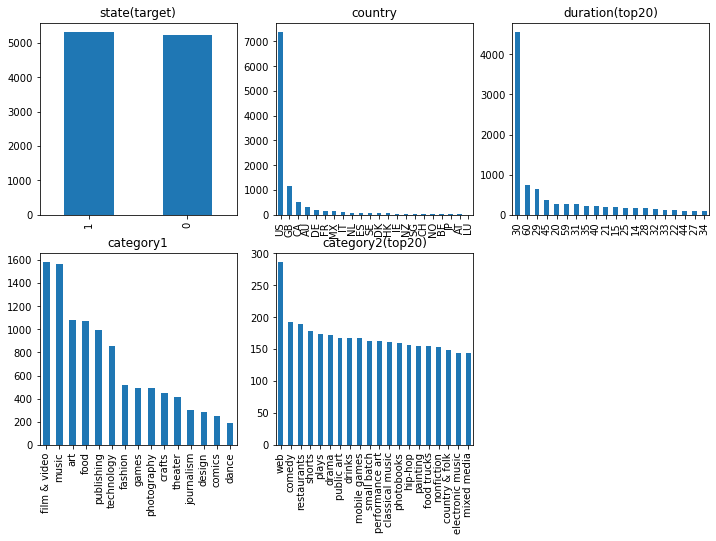

In [8]:
plt.figure(figsize=(12,12))

plt.subplot(3,3,1)
plt.title('state(target)')
train.state.value_counts().plot(kind='bar')

plt.subplot(3,3,2)
plt.title('country')
train.country.value_counts().plot(kind='bar')

plt.subplot(3,3,3)
plt.title('duration(top20)')
train.duration.value_counts()[:20].plot(kind='bar')

plt.subplot(3,3,4)
plt.title('category1')
train.category1.value_counts().plot(kind='bar')

plt.subplot(3,3,5)
plt.title('category2(top20)')
train.category2.value_counts()[:20].plot(kind='bar')

In [12]:
def check_diff_element(train, test, column):
    tr_elements = set(train[column])
    tes_elements = set(test[column])
    for tr_element in tr_elements:
        if not tr_element in tes_elements:
            print(f"{tr_element} is not in {column} of test_data")
    for tes_element in tes_elements:
        if not tes_element in tr_elements:
            print(f"{tes_element} is not in {column} of train_data")

In [14]:
check_diff_element(train, test, "category1")
check_diff_element(train, test, "category2")
check_diff_element(train, test, "country")

toys is not in category2 of train_data


In [15]:
test[test["category2"] == "toys"]

,id,goal,country,duration,category1,category2,html_content
9551,20096,22001-23000,DE,30,design,toys,"<div class=""contents""><div><h1 class=""page-anc..."


In [16]:
def add_column_about_goalrange(df):
    df["goal_min"] = df["goal_max"] = 0
    for n in tqdm(range(len(df))):
        try:
            df["goal_min"][n], df["goal_max"][n] = map(int, df["goal"][n].split('-'))
        except:
            df["goal_min"][n] = int(df["goal"][n].rstrip('+'))
            df["goal_max"][n] = np.nan
    return df

train_added = add_column_about_goalrange(train)
train_added.head(13)

  0%|          | 0/10545 [00:00<?, ?it/s]<ipython-input-16-cf12af63ff78>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["goal_min"][n], df["goal_max"][n] = map(int, df["goal"][n].split('-'))
<ipython-input-16-cf12af63ff78>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["goal_min"][n] = int(df["goal"][n].rstrip('+'))
<ipython-input-16-cf12af63ff78>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["goal_max"][n] = np.nan
/Ap

,id,goal,country,duration,category1,category2,html_content,state,goal_min,goal_max
0,0,4001-5000,CH,29,publishing,young adult,"<div class=""contents""><div><span class=""bold"">...",0,4001,5000.0
1,1,3001-4000,NL,34,fashion,ready-to-wear,"<div class=""contents""><div><h1 class=""page-anc...",0,3001,4000.0
2,2,19001-20000,US,30,food,spaces,"<div class=""contents""><div><p> As our society ...",0,19001,20000.0
3,3,2001-3000,US,41,technology,3d printing,"<div class=""contents""><div><p>My name is Donal...",0,2001,3000.0
4,4,2001-3000,GB,29,technology,diy electronics,"<div class=""contents""><div><div class=""templat...",1,2001,3000.0
5,5,1-1000,US,19,photography,fine art,"<div class=""contents""><div><h1 class=""page-anc...",1,1,1000.0
6,6,3001-4000,GB,59,fashion,apparel,"<div class=""contents""><div><p>We are raising f...",0,3001,4000.0
7,7,1-1000,US,20,art,mixed media,"<div class=""contents""><div><p>Hello world,</p>...",1,1,1000.0
8,8,2001-3000,US,28,publishing,periodicals,"<div class=""contents""><div><p>You are cool wit...",1,2001,3000.0
9,9,1001-2000,GB,21,film & video,documentary,"<div class=""contents""><div><h1 class=""page-anc...",1,1001,2000.0


In [8]:
train.goal_max

0         5000.0
1         4000.0
2        20000.0
3         3000.0
4         3000.0
          ...   
10540     1000.0
10541     1000.0
10542    20000.0
10543     1000.0
10544    75000.0
Name: goal_max, Length: 10545, dtype: float64

In [9]:
train.country.unique()

array(['CH', 'NL', 'US', 'GB', 'CA', 'ES', 'FR', 'DE', 'AU', 'IT', 'MX',
       'NZ', 'NO', 'DK', 'HK', 'SG', 'BE', 'SE', 'IE', 'JP', 'AT', 'LU'],
      dtype=object)

In [10]:
train.duration.unique()

array([29, 34, 30, 41, 19, 59, 20, 28, 21, 35, 27, 60, 40, 33, 31, 39, 44,
       54, 25, 22, 45,  8, 53, 48, 18, 14, 24, 32, 36, 57, 38, 50, 15, 58,
        3,  2, 47, 26, 43,  7, 23, 12, 42, 37, 56, 10, 89, 13, 55, 11, 16,
        9, 49, 52, 17, 61,  4, 51, 46,  6,  5, 74, 70, 81, 90,  1, 72, 85,
       76, 80, 84, 71, 86])

In [11]:
train.category1.unique()

array(['publishing', 'fashion', 'food', 'technology', 'photography',
       'art', 'film & video', 'dance', 'design', 'games', 'journalism',
       'music', 'comics', 'theater', 'crafts'], dtype=object)

In [12]:
train.category2.unique()

array(['young adult', 'ready-to-wear', 'spaces', '3d printing',
       'diy electronics', 'fine art', 'apparel', 'mixed media',
       'periodicals', 'documentary', 'graphic design', 'animation',
       'fantasy', 'gaming hardware', 'performance art', 'shorts', 'print',
       'video games', 'photobooks', 'flight', 'indie rock', 'nonfiction',
       'drinks', 'public art', 'vegan', 'science fiction',
       'playing cards', 'fiction', 'performances', 'webcomics',
       'conceptual art', 'accessories', 'hip-hop', 'wearables',
       'music videos', 'pop', 'digital art', 'video', 'country & folk',
       'art books', 'calendars', 'plays', 'restaurants', 'food trucks',
       'live games', 'horror', 'rock', 'comedy', 'narrative film',
       'electronic music', 'places', 'people', 'immersive', 'woodworking',
       'jazz', 'civic design', 'webseries', "farmer's markets",
       'footwear', 'classical music', 'interactive design', 'jewelry',
       'mobile games', 'illustration', 'festiva

In [13]:
train.html_content

0        <div class="contents"><div><span class="bold">...
1        <div class="contents"><div><h1 class="page-anc...
2        <div class="contents"><div><p> As our society ...
3        <div class="contents"><div><p>My name is Donal...
4        <div class="contents"><div><div class="templat...
                               ...                        
10540    <div class="contents"><div><h1 class="page-anc...
10541    <div class="contents"><div><p>This past Novemb...
10542    <div class="contents"><div><p><span class="bol...
10543    <div class="contents"><div><h1 class="page-anc...
10544    <div class="contents"><div><p>Do you take your...
Name: html_content, Length: 10545, dtype: object

In [21]:
html_0 = train.html_content[0]

In [25]:
print(html_0)

<div class="contents"><div><span class="bold">Mark Saggia</span> is an Italian writer who emigrated in Switzerland.<p>He is a Nerd, Star Wars, Marvel Comics and videogames Fanatic! IT's part of his entire life.</p><p>The story born when Mark, thinking about The Big Bang Theory, understood that what's missing in the world is a nerd story for who loves videogames and all "things" like this. A story wrote in typical nerd language.</p><p>The book has been published in Italian. It can be found at amazon.it or via Facebook. You can find some info at <a href="http://dummy.com" to a large one, who wouldn't have respect for his ideas. </p><p>They can do many things, sometimes only for money, that's not our idea of success. </p><p>This means that our small, unique, caring publisher, can’t reach the USA. No matter how hard they tries.</p><p>Money for printing, find someone for distribution, marketing and other things are needed. </p><p>So we ventured to USA. We searched and searched….and finally 

In [30]:
import nltk
from bs4 import BeautifulSoup

In [32]:
raw = BeautifulSoup(html_0).get_text()

In [34]:
print(raw)

Mark Saggia is an Italian writer who emigrated in Switzerland.He is a Nerd, Star Wars, Marvel Comics and videogames Fanatic! IT's part of his entire life.The story born when Mark, thinking about The Big Bang Theory, understood that what's missing in the world is a nerd story for who loves videogames and all "things" like this. A story wrote in typical nerd language.The book has been published in Italian. It can be found at amazon.it or via Facebook. You can find some info at They can do many things, sometimes only for money, that's not our idea of success. This means that our small, unique, caring publisher, can’t reach the USA. No matter how hard they tries.Money for printing, find someone for distribution, marketing and other things are needed. So we ventured to USA. We searched and searched….and finally found someone that can help us distribute in the USA. This is where you come in…..we’d like you to participate in this project, to help an average person have success that he worked 